lipid bilayer, air-water system

In [1]:
import os.path
import numpy as np
import matplotlib.pyplot as plt
# import scipy
from refnx.version import version
from refnx.dataset import ReflectDataset, Data1D
from refnx.analysis import Transform, CurveFitter, Objective, Model, Parameter
from refnx.reflect import SLD, Slab, ReflectModel, LipidLeaflet
from sepObjectiveGO import getObjective as gO
from dynesty import DynamicNestedSampler
from dynesty import plotting as dyplot
from CFitter import CFitter
import make_sim_data as msd
print('refnx: %s\nnumpy: %s' % (version,
                    np.version.version))
%matplotlib inline

refnx: 0.1.9
scipy: 1.3.0
numpy: 1.16.4
refnx: 0.1.9
numpy: 1.16.4


In [2]:
def aPlotter(res, interestingNo, spacesize, figI):
    print(figI)
    # no = -1000
    # slc = slice(no-1000,no)
    useAbleLow=0.1
    useAbleHigh=10.
    xall=np.linspace(0,spacesize,len(res["logz"]))
    print("len",len(res["logz"]), "space size", spacesize)
    useable=np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if np.exp(y)>useAbleLow and np.exp(y)<=useAbleHigh]))
    # print(len(res["logz"]),res["logz"][slc])#summary()
    interesting = np.transpose(np.array([[x,y] for y,x in zip(res["logz"],xall) if x>=float(interestingNo)]))#.reshape((2,-2))
#     print("len 2", len(interesting[0]), len(interesting), interesting[0,:3])
    print("logz max: ",max(res["logz"]),",min: ",min(res["logz"]))
    print("z max: ",max(np.exp(res["logz"])),",min: ",min(np.exp(res["logz"])))
#     print(res["logz"][:5],interesting[1,:5],useable[1,:5])
    # print("interesting")
#     xall=np.linspace(0,spacesize,len(res["logz"]))
#     xusable=np.linspace(0,spacesize,len(useable))
    plt.figure(figI)
    figI+=1
    if len(useable)>=2:
        n_plots = 3
    else:
        n_plots = 2
    plt.subplot(1, n_plots, 1)
    plt.plot(xall,res["logz"])
    if any([lnz<=0 for lnz in res["logz"]]):
        plt.title("ln(evidence)\n not log scaled vs -ln(X)")
        plt.plot(xall, [0 for value in xall], label="ln(evidence)=0", alpha=0.4,linestyle="--")
    else:
        plt.title("ln(evidence)\n log scaled vs -ln(X)")
        plt.yscale("log")
    plt.xlabel("-ln(X)")
    plt.ylabel("ln(evidence)")
#     plt.figure(figI)
#     figI+=1
    plt.subplot(1, n_plots, 2)
    plt.plot(interesting[0],interesting[1])
    plt.title("interesting values\n ln(evidence)\n"+r" vs -ln(X) $\geq %d$" % interestingNo)
    plt.xlabel("-ln(X)")
    plt.ylabel("ln(evidence)")
    if len(useable)>=2:
        plt.subplot(1, n_plots, 3)
        plt.plot(useable[0],useable[1])
        plt.title("usful values\n"+r"ln(%.3f<evidence $\leq$ %.3f) vs -ln(X)"%(useAbleLow,useAbleHigh))
        plt.xlabel("-ln(X)")
        plt.ylabel("ln(evidence)")
    else:
        print("not enough 'usable' data points")
    print(figI)
    plt.tight_layout()
    return figI

def min_interesting_lnX(res):
    returns = None
    for lnX, logz in zip(res["logvol"], res['logz']):
        if logz >= 0.:
            break
        else:
            returns = -lnX
#     returns = min([-lnX for lnX, wt in zip(res["logvol"], np.exp(res['logwt'] - res['logz'][-1])) if wt>0])
    return returns

maxLength = 80
def logp_extra(model, data=None):
    returns = 0
    if sum(model.structure.slabs()[1:-1,0])>maxLength:
        returns = -np.inf
    return returns

In [3]:
#making layers

# SLDs
def makeTrue():
    air = SLD(0 +0j)
    h2o = SLD(-0.56 + 0j) # ?
    si = SLD(2.07 + 0j)
    sio2 = SLD(3.47 + 0j)

    apm = Parameter(56, 'area per molecule', vary=True, bounds=(52, 65))
    b_heads = Parameter(6.01e-4, 'b_heads')
    b_tails = Parameter(-2.92e-4, 'b_tails')
    v_heads = Parameter(319, 'v_heads')
    v_tails = Parameter(782, 'v_tails')
    inner_head_thickness = Parameter(9, 'inner_head_thickness', vary=True, bounds=(4, 11))
    outer_head_thickness = Parameter(9, 'outer_head_thickness', vary=True, bounds=(4, 11))
    tail_thickness = Parameter(14, 'tail_thickness', vary=True, bounds=(10, 17))

    inner_leaflet = LipidLeaflet(apm,
                                 b_heads, v_heads, inner_head_thickness,
                                 b_tails, v_tails, tail_thickness,
                                 3, 3)
    outer_leaflet = LipidLeaflet(apm,
                                 b_heads, v_heads, outer_head_thickness,
                                 b_tails, v_tails, tail_thickness,
                                 3, 0, reverse_monolayer=True)


    solv_roughness = Parameter(3, 'bilayer/solvent roughness')
    solv_roughness.setp(vary=True, bounds=(0, 5))

    s_h2o = air | inner_leaflet | outer_leaflet | h2o(0, solv_roughness)
    return s_h2o
# model_h2o.bkg.setp(vary=True, bounds=(-1e-6, 1e-6))
# objective_h2o = Objective(model_h2o, data_h2o)
true_s_h2o = makeTrue()


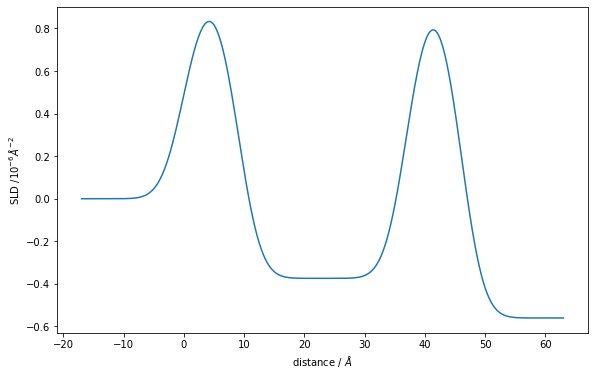

In [4]:
figI=0
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.figure(figI)
figI+=1
plt.plot(*true_s_h2o.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

In [5]:
true_model_h2o = ReflectModel(true_s_h2o)
resolution = 5.
q = np.linspace(0.001, 0.35, 70)
R = true_model_h2o(q, x_err=resolution)
sim_dR = msd.main(sim_q=q,sim_R=R)
data = Data1D(data= (q,R,sim_dR))

csv
cvs-collecting
out  [3.47819830e+02 8.77904741e+01 3.20810699e+03 9.49732939e-37
 1.65307010e-05] 
var:  [[1.76447440e+01 1.39762075e+02 1.90993913e+00 2.55098590e+04
  6.99628049e-05]
 [1.39762075e+02 1.10704093e+03 1.51284720e+01 2.01610925e+05
  5.54070662e-04]
 [1.90993913e+00 1.51284720e+01 2.06742813e-01 2.73481708e+03
  7.56735044e-06]
 [2.55098590e+04 2.01610925e+05 2.73481708e+03 2.55670288e+08
  1.48331018e-01]
 [6.99628049e-05 5.54070662e-04 7.56735044e-06 1.48331018e-01
  2.92147690e-10]]


<ErrorbarContainer object of 3 artists>

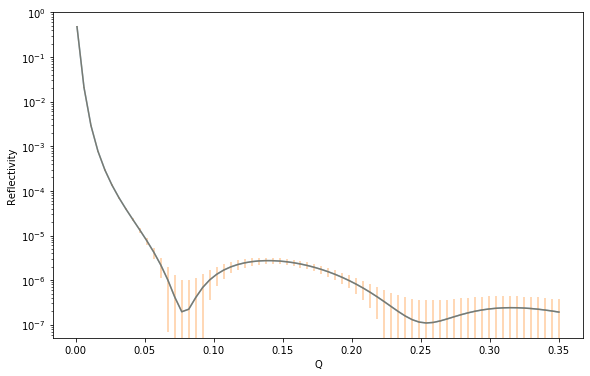

In [6]:
plt.figure(figI)
figI+=1
plt.plot(q,R)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.yscale('log')
plt.errorbar(q,R,sim_dR,alpha=0.4)

In [7]:
air = SLD(0 + 0j)
h2o = SLD(-0.56 + 0j)
si = SLD(2.07 + 0j)
sio2 = SLD(3.47 + 0j)

apm = Parameter(56, 'area per molecule', vary=True, bounds=(52, 65))
b_heads = Parameter(6.01e-4, 'b_heads')
b_tails = Parameter(-2.92e-4, 'b_tails')
v_heads = Parameter(319, 'v_heads')
v_tails = Parameter(782, 'v_tails')
inner_head_thickness = Parameter(9, 'inner_head_thickness', vary=True, bounds=(4, 11))
outer_head_thickness = Parameter(9, 'outer_head_thickness', vary=True, bounds=(4, 11))
tail_thickness = Parameter(14, 'tail_thickness', vary=True, bounds=(10, 17))

inner_leaflet = LipidLeaflet(apm,
                             b_heads, v_heads, inner_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             3, 3)
outer_leaflet = LipidLeaflet(apm,
                             b_heads, v_heads, outer_head_thickness,
                             b_tails, v_tails, tail_thickness,
                             3, 0, reverse_monolayer=True)

solv_roughness = Parameter(3, 'bilayer/solvent roughness')
solv_roughness.setp(vary=True, bounds=(0, 5))

s_h2o = air | inner_leaflet | outer_leaflet | h2o(0, solv_roughness)

In [8]:
model_h2o = ReflectModel(s_h2o,bkg=0,dq=5.)
objective = Objective(model_h2o, data,
                  transform=Transform('logY'),logp_extra=logp_extra)


In [9]:
# objective = gO(data, 1) #06:09
fitter = CFitter(objective)
DNSampler = DynamicNestedSampler(fitter.logl, fitter.priorTransform, fitter.nDim())
DNSampler.run_nested(dlogz_init=0.01)
res1 = DNSampler.results

18452it [05:19, 57.77it/s, batch: 8 | bound: 83 | nc: 4 | ncall: 82203 | eff(%): 22.447 | loglstar: 47.648 < 55.742 < 54.851 | logz: 48.052 +/-  0.137 | stop:  0.995]           


Text(0, 0.5, 'log R')

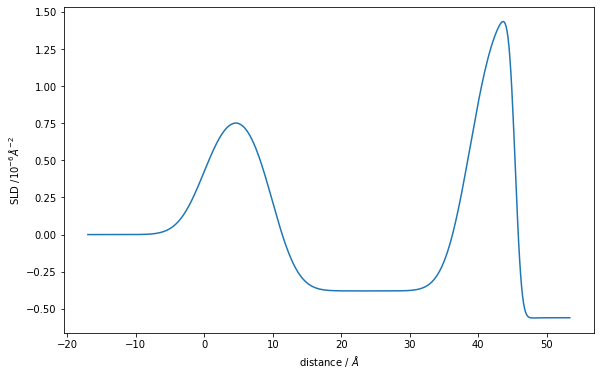

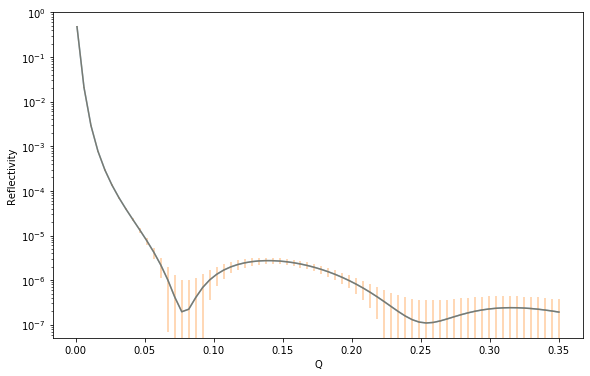

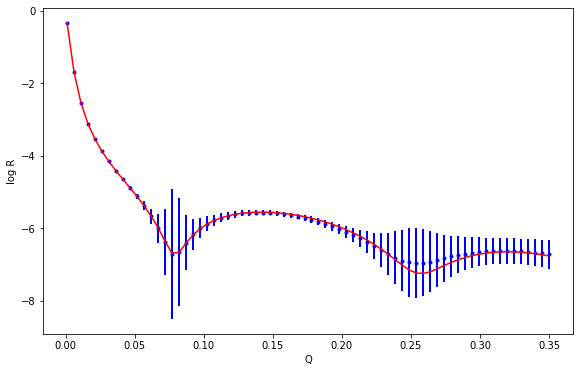

In [10]:
plt.rcParams['figure.figsize'] = [9.5, 6]
plt.figure(figI)
figI+=1
plt.plot(*s_h2o.sld_profile())
plt.ylabel('SLD /$10^{-6} \AA^{-2}$')
plt.xlabel('distance / $\AA$');

plt.figure(figI)
figI+=1
plt.plot(q,R)
plt.xlabel('Q')
plt.ylabel('Reflectivity')
plt.yscale('log')
plt.errorbar(q,R,sim_dR,alpha=0.4)

objective.plot()
# plt.legend()
plt.xlabel('Q')
plt.ylabel('log R')
# plt.yscale('log');

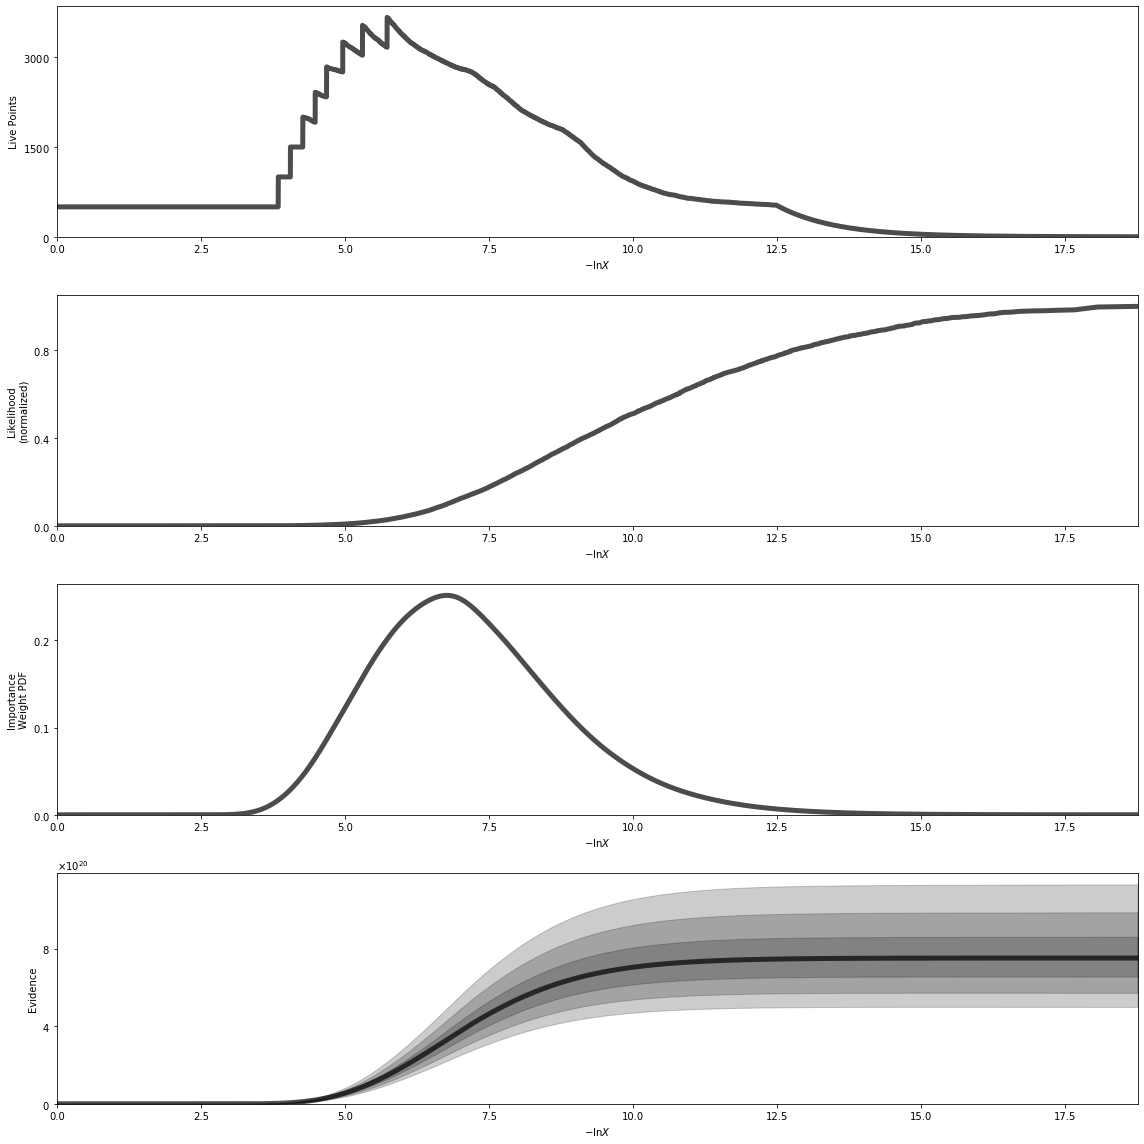

In [11]:
# span = [(0,5000),(0,1.5),(0,0.4),(10**0,10**10)] #,span=span
fig, axes = dyplot.runplot(res1, color='black', mark_final_live=False,
                           logplot=False)
fig.tight_layout()

4
len 18452 space size 29
logz max:  48.0689212693651 ,min:  -1539.1116446636845
z max:  7.51739305382608e+20 ,min:  0.0
5


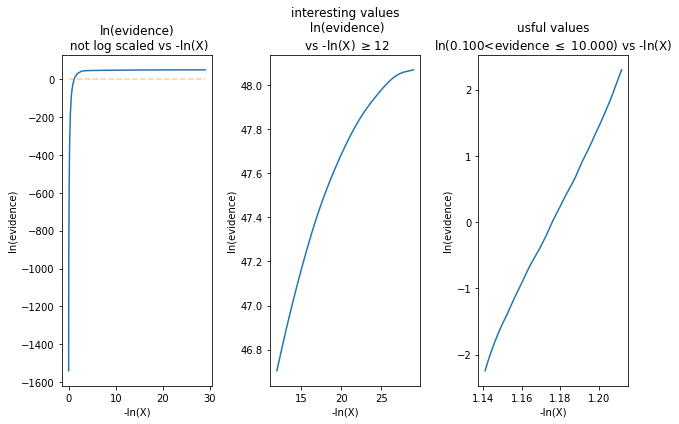

In [12]:
figI = aPlotter(res1, 12, 29, figI)

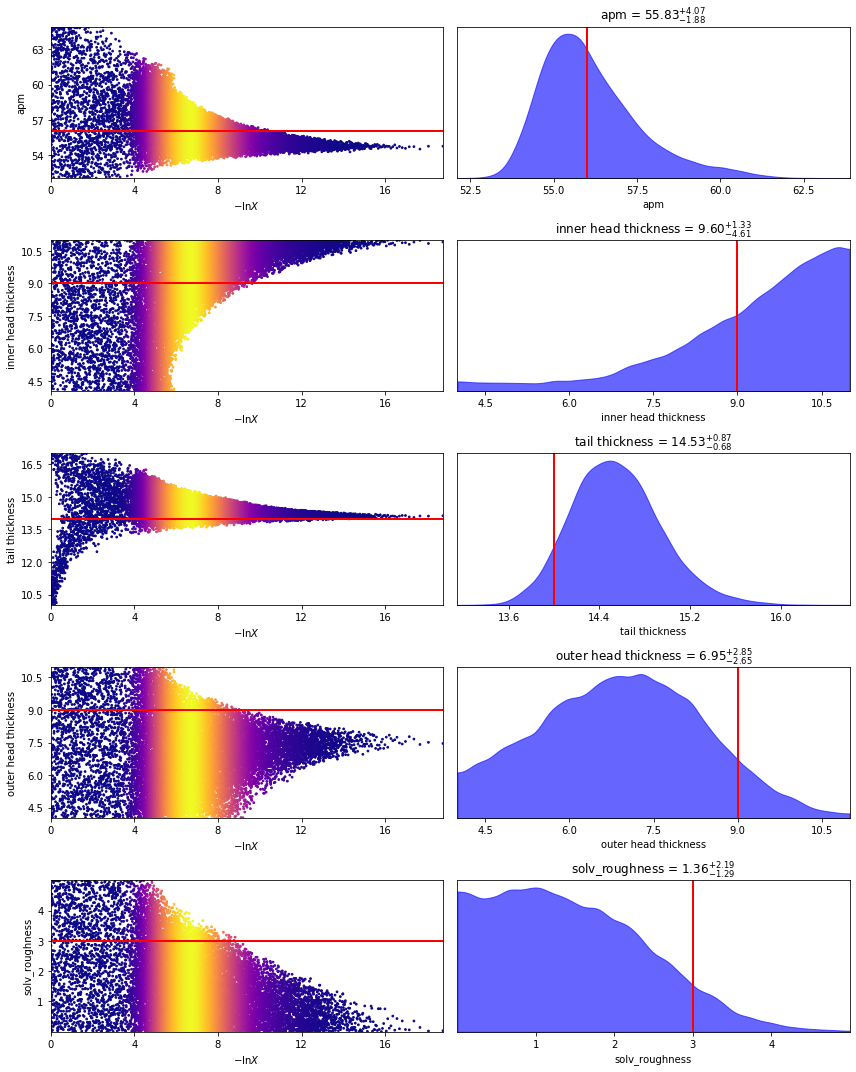

In [13]:
labels = ["apm", "inner head thickness", "tail thickness", "outer head thickness", "solv_roughness"]
true_values = [56, 9, 14, 9, 3]
fig, axes = dyplot.traceplot(res1, labels=labels, truths=true_values,
                             show_titles=True, trace_cmap='plasma',
                             quantiles=None)
fig.tight_layout()